<span style="color: Gold"> RAG

<span style="font-size:13px;">

- 학습데이터에 없는 최신/특정 정보를 모르는 LLM의 한계를 극복할 수 있는 모델
- 기본 원리 : 외부 문서에서 관련 정보를 '검색'하고, 검색된 내용을 LLM에게 '컨텍스트'로 제공하여 답변을 '생성'하는 3단계의 프로세스
- 기본 구현: 간단한 텍스트 문서를 llama-index를 사용하여 벡터화하고, 인덱스를 생성한 뒤, 질문에 대한 답변을 얻는 기본적인 RAG 파이프라인을 시연
- 고급 설정: 검색 정확도와 효율성에 영향을 주는 주요 파라미터들을 조정
    - 청크 크기(chunk_size)
    - 청크 간 겹침(chunk_overlap)
    - 유사도 상위 K개(similarity_top_k)
    - 유사도 임계값(similarity_cutoff)
- **흐름**:
<span style="color: yellow"> 질문 → 문서 검색 → 관련 정보 선택 → LLM에게 컨텍스트 전달 → 답변 생성
- **장점**: 최신 정보나 특정 데이터 기반 답변 가능
- **단점**: 검색 단계가 없으면 LLM은 일반 지식만 답함

<span style="color: Gold"> LlamaIndex

<span style="font-size:13px;">

- **정의**: RAG 전략을 **실제로 구현하도록 돕는 라이브러리/도구**
- **핵심 기능**:
  1. 문서를 **청크 단위로 분할** → 모델 입력 제한 해결
  2. **청크 벡터화** → 벡터 DB에 저장
  3. 질문 벡터와 청크 벡터 **유사도 계산** → 상위 K개 선택
  4. 선택된 청크를 **LLM에 전달** → 답변 생성
  5. 후처리 및 배치 처리 옵션 제공

- **흐름**:   
<span style="color: yellow">
문서 → 청크 분할 → 벡터화 → 벡터DB 저장  
질문 → 벡터화 → 유사도 검색 → 상위 청크 선택 → LLM → 답변  

<span style="color: Gold">관계

<span style="font-size:13px;">

| 개념         | 역할                                    |
|--------------|---------------------------------------|
| **RAG**      | 전략/아이디어 (“검색 + 생성”)          |
| **LlamaIndex** | 도구/라이브러리 (RAG 구현 브릿지)      |

<br> 
 
> 즉, LlamaIndex 안에 RAG 개념이 들어 있다고 생각하면 된다.    
> LlamaIndex가 RAG를 실제 코드로 쉽게 구현하게 해주는 역할.  

---

In [ ]:
%pip install llama-index

In [9]:
from llama_index.core import Document,VectorStoreIndex       # Document,VectorStoreIndex  문서를 벡터화해서 저장해서 인덱스화 했다

<span style="color: Gold"> 1. 문서준비/ 인덱스 생성/ 쿼리 엔진 생성/ 쿼리 실행

In [ ]:
# 1. 문서 준비
import openai
import os
from openai import OpenAI
client = OpenAI()

document = [
    Document(text='대한민국의 수도는 서울입니다.'),
    Document(text="프랑스의 수도는 파리 입니다.")
]
# 2 인덱스 생성(자동으로 벡터화)
# 각 청크를 openai api 로 벡터화
# 인메모리방식으로 벡터 스토어에 저장   # 인메모리: 디스크에 저장하지 않고 메모리에 바로 저장/ # 벡터 스토어 : 저장된 벡터들을 검색 가능하게 모아둔 공간
index = VectorStoreIndex.from_documents(document)       # 문서를 숫자로 바꿔서 검색 가능한 형태로 만든다/ 문서를 자동으로 임베딩→벡터 저장하여 벡터 인덱스 생성

# 3 쿼리 엔진 생성
query_engine = index.as_query_engine(similarity_top_k=2)        # 인덱스를 이용해 질의할 수 있는 엔진 생성. 질문이 들어오면 유사도 상위 2개 청크를 찾아 사용할 것이라는 설정

# 4 쿼리 실행
response = query_engine.query("대한민국의 수도는 어디입니까?")  # 질문을 임베딩하고 → 벡터 검색하고 → 찾은 청크를 LLM 컨텍스트로 전달해 답변 생성
print(response)

서울


<span style="color: Gold"> 2. 청크/ 유사도 임계값 설정

<span style="font-size:13px;">

- 청크
    - 문서 검색의 최소단위 모델이 한번에 처리할 수 있는 길이로 잘라낸 텍스트. <span style="color: yellow"> 숫자가 아닌 단순 문자열 </span>
        - 예시
            - 원문: "대한민국의 수도는 서울입니다. 서울은 정치, 경제 중심지입니다."
            - 청크1: "대한민국의 수도는 서울입니다."
            - 청크2: "서울은 정치, 경제 중심지입니다."
    - 모델 입력 길이 제한, 문서가 길면 한번에 처리 할수 없어서 청크로 나눠 처리
    - 벡터 DB에서 문서전체가 아니라 청크단위로 벡터화
    - 질문과 유사한 작은 단위를 찾아 답변을 생성
    - 전체 문서를 이해하는 대신 청크로 처리해서 중요한 부분에 집중
<br>     
<span style="color: skyblue;">
-> 청크의 사이즈가 작을수록 정확한 검색, 많은 API 호출  
-> 청크의 사이즈가 클수록 넓은 컨텍스트, 적은 API 호출  
<br>       
- 유사도    
    - 문서(혹은 청크)와 질문을 벡터로 변환
    - 코사인 유사도 등으로 두 벡터가 얼마나 비슷한지 계산 (값 범위: 0~1)     

</span>
<br>  
<span style="color: yellow;">
★★★ 청크화된 텍스트를 임베딩 모델로 벡터화(숫자)하여 코사인유사도를 계산한다 ★★★ 

In [ ]:

from llama_index.core import Settings
Settings.chunk_size = 512 # 기본값  # 한 청크의 최대 토큰/글자 길이
Settings.chunk_overlap = 50 # 청크 간 겹침  
# 겹치게 하는 이유: 문장이 잘리는 경우 정보 손실 방지. 겹치지 않으면 중요한 문맥이 끊길 수 있음

# 유사도 임계값 설정 -> 청크가 질문과 충분히 관련 있는지 판단하는 기준
from llama_index.core.postprocessor import SimilarityPostprocessor
query_engine = index.as_query_engine(
     similarity_top_k=2,  # 유사도 상위 2개
     node_postprocessors=[
         SimilarityPostprocessor(similarity_cutoff=0.7)]  # 유사도 0.7 미만의 문서는 제거 (노이즈 제거)/ 모델이 질문과 관련 있는 청크만 읽고 답변하게 됨
 )

# 배치 처리
Settings.embed_batch_size = 100 # 청크를 벡터화 할 떄 한 번에 처리하는 청크 수


---

##### <span style="color: pink"> <한국어 데이터로 RAG 구현> </span>

<span style="font-size:13px;">

- 위에는 영어 문서/벡터/엔진이기 때문에 한국어 문서에 그대로 사용할 수 없음  
=> 벡터 공간이 다르고, 임베딩 모델이 언어별로 달라서 유사도 계산이 의미 없음  

In [12]:
# 한국어 데이터로 RAG 구현
from llama_index.core import Document,VectorStoreIndex,Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

<span style="color: Gold"> 1. 임베딩 모델 선정

In [ ]:
# LLM 임베딩 모델 설정
Settings.llm = OpenAI(model="gpt-4o-mini", temperature=0.1)     # RAG에서 질문에 대한 답변을 모델과 랜덤성 제어를 설정
                                                                # 낮으면 → 더 결정적, 안정적 답변 / 높으면 → 다양하고 창의적 답변
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")  #  OpenAIEmbedding 청크 텍스트 → 숫자 벡터(임베딩)

<span style="color: Gold"> 2. 문서 준비

In [13]:

# 2. 문서 준비
documents = [
    Document(
        text="김치는 한국의 대표적인 발효 음식입니다. 배추에 고춧가루, 마늘, 생강 등을 넣어 만듭니다.",
        metadata={"source": "한국 음식 백과", "category": "반찬"}
    ),
    Document(
        text="비빔밥은 밥 위에 여러 가지 나물과 고기, 계란을 올려 고추장과 섞어 먹는 음식입니다.",
        metadata={"source": "한국 음식 백과", "category": "밥 요리"}
    ),
    Document(
        text="불고기는 양념한 소고기를 구워 먹는 한국의 전통 음식입니다. 달콤하고 짭짤한 맛이 특징입니다.",
        metadata={"source": "한국 음식 백과", "category": "고기 요리"}
    ),
    Document(
        text="떡볶이는 가래떡에 고추장 양념을 넣어 볶은 한국의 길거리 음식입니다. 달콤하고 매운 맛이 특징입니다.",
        metadata={"source": "한국 음식 백과", "category": "분식"}
    ),
]
     

<span style="color: Gold"> 3. 벡터 인덱스 생성

In [14]:
# 3. 벡터 인덱스 생성
index = VectorStoreIndex.from_documents(documents)

<span style="color: Gold"> 4. 쿼리 엔진 생성

In [15]:
# 4. 쿼리 엔진 생성
query_engine = index.as_query_engine(
    similarity_top_k=2,
    # node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.7)]
) 

<span style="color: Gold"> 5. 질문하기

In [ ]:

# 5. 질문하기
questions = [
    '김치는 어떤 음식인가요?',
    '비빔밥을 어떻게 먹나요?',
    '한국의 고기 요리에는 뭐가 있나요?'
]
for q in questions:
  response = query_engine.query(q)  
  # 질문 q를 벡터화하고 벡터와 저장된 청크 벡터 간 코사인 유사도를 계산한다
  # 유사도가 높은 청크를 선택
  # 선택된 청크 + 질문 -> LLM 전달 -> LLM 최종답변 -> 결과를 resoinse 변수에 저장
  print(f'질문:{q} 답변 :{response}')

질문:김치는 어떤 음식인가요? 답변 :김치는 한국의 대표적인 발효 음식으로, 배추에 고춧가루, 마늘, 생강 등을 넣어 만들어집니다.
질문:비빔밥을 어떻게 먹나요? 답변 :비빔밥은 밥 위에 여러 가지 나물과 고기, 계란을 올려 고추장과 섞어 먹는 음식입니다.
질문:한국의 고기 요리에는 뭐가 있나요? 답변 :불고기


---

##### <span style="color: pink"> LLM캐시</span>  
: 이전에 생성된 답변을 저장해 두고, 같은 질문이 들어오면 모델 호출 없이 바로 반환하는 시스템  

<span style="font-size:12px;">

- 완전 일치 캐시(Exact Match Cache)     
- 의미적 캐시 (Semantic Cache)  


<span style="font-size:11px;">
동일한 질문을 100번 반복해서 LLM에게 보내고 답변을 받는 과정 예시 코드

In [ ]:
# 동일한 질문을 반복하면
from openai import OpenAI
import openai
import time

client = OpenAI()
question = '대한민국의 수도는'

cache = {}    # 질문과 답변을 저장하는 간단한 캐시

start = time.time()
for i in range(100):    # 질문을 100번 반복하겠다
  response = client.chat.completions.create(  #   response = client.chat.completions.create : 이 모델에게 메시지를 주고 답변을 만들어 줘!
      model = 'gpt-4o-mini',
      messages = [{'role': 'user', 'content': question}],
      temperature = 0   # 항상 결정적 답변  
  )
  answer = response.choices[0].message.content
  cache[question] = answer  # 질문을 key, 답변을 value로 해서 cache 저장
elapsed_time = time.time() - start  # 100번 수행 시간 측정
print(f'elapsed_time: {elapsed_time}')

elapsed_time: 82.07667136192322


<span style="color: Gold"> 1. 완전 일치 캐시(Exact Match Cache)

<span style="font-size:13px;">

- 동일한 입력 -> 저장된 응답 반환
- 장점 : 구현이 간단하고 100% 정확
- 단점 : 완전히 같아야만 작동
- 예시 질문: " 대한민국의 수도는?"
    - 대한민국의 수도는 ? 캐시 히트
    - 대한민국 수도는?    캐시 미스(다른 문자열) --> '의' 없음
    - 한국의 수도는?      캐시 미스

In [ ]:
cache = {}
response = []
for i in range(100):
  if question in cache :
    answer = cache[question]  # 질문이 이미 캐시에 있으면 캐시에서 답변을 가져온다

<span style="color: Gold"> 2. 의미적 캐시 (Semantic Cache)

<span style="font-size:13px;">

- 의미가 비슷한 입력 -> 저장된 응답 반환
- 장점: 높은 히트율/ 다양한 표현을 허용하여 유연/ 비용 절감
- 단점: 약간 느림/ 벡터 DB가 필요
- 과정:
     1. 유사도 프롬프트 검색
     2. 유사도 확인 (특정 임계값을 지정해서 그 값에 따라서 답변 채택 종료)
     3. 비슷한게 없으면 LLM 호출

In [ ]:
%pip install chromadb

In [ ]:
%pip install sentence-transformers

###### <span style="color: lightblue;"> 벡터 DB (3_2.vetorDB 파일 참고)

In [ ]:
# 벡터스토어 -> DB
# 문서나 텍스트를 벡터로 변환한 후 저장 - 유사도 기반 검색 기능
import chromadb # chromadb 유사도 기반으로 검색하는 것
client = chromadb.Client()
# 컬렉션 생성
collection = client.create_collection('my_collection2') # my_collection2 돌릴때마다 이름을 바꾸는 이유는 ChromaDB에서 컬렉션 이름은 유니크해야하기 떄문. 같은 이름으로 만들면 오류날 수 있음 
# 문서와 임베딩 준비
texts = [
    '대한민국의 수도는 서울입니다.',
    '프랑스의 수도는 파리입니다.',
    '서울은 한국의 정치, 경제의 중심지 입니다'
]
from sentence_transformers import  SentenceTransformer  #  SentenceTransformer : 문장을 벡터로 변환하는 모델
model = SentenceTransformer('all-MiniLM-L6-v2') # 'all-MiniLM-L6-v2' → 사전학습된 임베딩 모델
embeddings = model.encode(texts).tolist()   # texts의 각 문장을 벡터화(임베딩)/ 출력은 (문서수, 벡터차원)
embeddings  # (3,384) 차원으로 임베딩

[[-0.02381489798426628,
  0.08707407861948013,
  0.07979418337345123,
  -0.010389548726379871,
  -0.038701772689819336,
  -0.029341010376811028,
  0.1098581999540329,
  0.015440716408193111,
  -0.011002996936440468,
  -0.009104168973863125,
  0.08716967701911926,
  -0.046011343598365784,
  0.049076396971940994,
  -0.07741815596818924,
  0.08031684905290604,
  -0.03652263432741165,
  0.04435156658291817,
  0.051641643047332764,
  -0.10573046654462814,
  0.03171825036406517,
  0.025493714958429337,
  -0.00490877078846097,
  0.029756693169474602,
  0.028301818296313286,
  -0.06878554821014404,
  -0.02731386013329029,
  0.005474086385220289,
  -0.012014423497021198,
  0.07081887125968933,
  0.041178226470947266,
  -0.02017919160425663,
  0.06898636370897293,
  0.028437955304980278,
  0.07568582892417908,
  -0.06454993039369583,
  0.04482787847518921,
  -0.06224125251173973,
  0.019267577677965164,
  -0.01746963895857334,
  -0.00829229224473238,
  -0.15329045057296753,
  -0.1490267366170883

In [20]:
# 문서추가
ids = ['doc1','doc2','doc3']
collection.add(
    ids = ids,
    documents = texts,
    embeddings = embeddings
)

In [21]:
# 유사도 검색
query = '한국의 수도는 어디인가요?'
query_embedding = model.encode(query).tolist()
results = collection.query(
    query_embeddings = model.encode(query).tolist(),
    n_results = 1
)
results

{'ids': [['doc1']],
 'embeddings': None,
 'documents': [['대한민국의 수도는 서울입니다.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None]],
 'distances': [[0.39439284801483154]]}

<span style="color: Gold"> 3. 다층 캐시 전략

<span style="font-size:13px;">

메모리(완전일치) -> 미스 -> 벡터 DB(의미적) -> 미스 -> LLM 호출

<span style="color: lightblue;">  1) 완전 일치 전체 구조

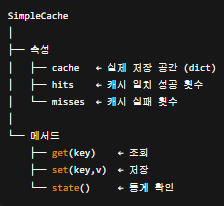

In [2]:
# 1. 완전 일치
class SimpleCache :
    def __init__(self) :        # 속성
      self.cache = {} # 딕셔너리/ 실제 저장 공간
      self.hits = 0   # 캐시 일치 성공 횟수
      self.misses = 0 # 캐시 실패 횟수
    def get(self,key) :   # 조회
      if key in self.cache :  # 키가 딕셔너리 안에 있나 확인한다 → 완전 일치 체크
        self.hits += 1        # 있으면 hit
        return self.cache[key]
      self.misses += 1
      return None
    def set(self,key,value):    # 저장
      self.cache[key] = value
    def state(self):          # 통계 확인
      total = self.hits + self.misses
      hit_rate = self.hits/total*100 if total >0 else 0
      return{
          'hits':self.hits,
          'misses':self.misses,
          'hit_rate':hit_rate
      }

In [ ]:
# LLM에 요청/ 답변 형식 지정
import openai
from openai import OpenAI
client = OpenAI()

def call_llm(question):
  response = client.chat.completions.create(  # LLM 요청 보내기
      model = 'gpt-4o-mini',
      messages = [{'role':'user', 'content':question}],
      temperature = 0
    )
  return response.choices[0].message.content # choices[0] 0번쨰 후보 중 content 내용만 리턴해라

In [ ]:
from openai import OpenAI
import openai
client = OpenAI()

cache = SimpleCache()
questions = [
    '대한민국의 수도는',
    '대한민국의 수도는',  # 캐시히트
    '한국의 수도는'       # 캐시 미스 (다른 문자열)
]
for q in questions:
  cached = cache.get(q)
  if cached :
    print(f'캐시 : {cached}')
  else :
    response = call_llm(q)
    cache.set(q,response)
    print(f'llm : {response}')
  print(cache.state())

llm : 대한민국의 수도는 서울입니다.
{'hits': 0, 'misses': 1, 'hit_rate': 0.0}
캐시 : 대한민국의 수도는 서울입니다.
{'hits': 1, 'misses': 1, 'hit_rate': 50.0}
llm : 한국의 수도는 서울입니다.
{'hits': 1, 'misses': 2, 'hit_rate': 33.33333333333333}


In [ ]:
%pip install chromadb

<span style="color: lightblue;"> 2) 의미적 유사성 전체 구조

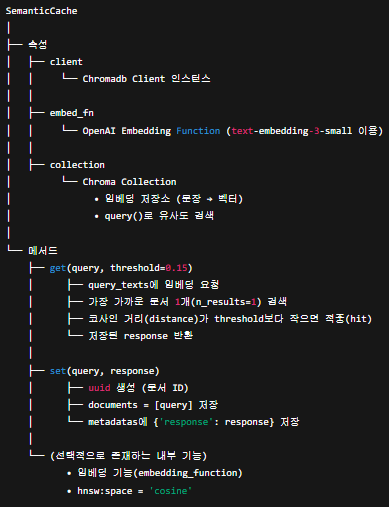

In [ ]:
# 2.의미적 유사성 - 벡터 DB chromadb
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
class SemanticCache:
  def __init__(self,name = 'semantic_cache' ) :
    self.client = chromadb.Client()             # 벡터를 저장할 컬렉션을 만든다
    self.embed_fn = OpenAIEmbeddingFunction(    # 임베딩 함수 정의
      api_key= os.environ['OPENAI_API_KEY'],
      model_name="text-embedding-3-small"
    )
    self.collection = self.client.create_collection(    # Chroma Collection 생성
    name = name,
    embedding_function=self.embed_fn,           # embedding_function: 문장을 벡터로 바꿀 함수 지정
    metadata = {'hnsw:space' : 'cosine'}  # 코사인 유사도
    )
  def get(self,query,threshold = 0.15):   # query 임베딩/ threshold(스레시홀드) : 이 정도면 비슷하다고 인정할 최소 기준선. 숫자가 적을수록 유사
    results = self.collection.query(      # collection 내부의 모든 문서 벡터와 비교
        query_texts = [query],
        n_results = 1                     # 가장 가까운 문서 1개를 가져온다
    )
    if results['distances'][0] and results['distances'][0][0] < threshold : # 거리 < threshold -> 유사도가 충분이 높으면 캐시 HIT
      return results['metadatas'][0][0]['response']
    return None 
  def set(self,query,response):  
    import uuid # 유니크한 아이디 생성
    self.collection.add(
    documents = [query],    # # query 문장을 documents로 저장
    metadatas = [{'respponse':response}], # response를 metadata에 저장, 
    ids =[str(uuid.uuid4())])

cache=SemanticCache(name='test2')

In [ ]:
# SemanticCache 사용

cache = SimpleCache()
questions = [
    '대한민국의 수도는',
    '대한민국의 수도는',  # 캐시히트
    '한국의 수도는'       # 캐시 미스 (다른 문자열)
]
for q in questions:
  cached = cache.get(q)
  if cached : # 캐시 HIT일때
    print(f'HIT :{q} - {cached}')
  else :
    response = call_llm(q)  # 캐시 MISS일 때 LLM을 호출한다
    cache.set(q,response)   # 그리고 그 답변을 캐시에 저장한다
    print(f'MISS : {q} - {response}')

MISS : 대한민국의 수도는 - 대한민국의 수도는 서울입니다.
HIT :대한민국의 수도는 - 대한민국의 수도는 서울입니다.
MISS : 한국의 수도는 - 한국의 수도는 서울입니다.


<span style="color: lightblue;"> 3) 멀티 캐시

In [ ]:
# 멀티 캐시
'''
L1 메모리 내부메모리 ... dictionary
L2 메모리 벡터 DB - 의미적 유사성
L3 메모리  LLM호출
'''

class MultiLevelCache:
  def __init__(self) -> None:
    self.l1_cach = SimpleCache()      # 메모리방식 dictionary   완전일치
    self.l2_cach = SemanticCache()    # ChoromaDB 벡터DB  유사도방식
  def stats(self):                    # 캐시 통계 확인 메서드
    print(f'L1 catch: {self.l1_cach.cache}')
  def get(self,key):                  # 답변 조회 메서드  
    cached = self.l1_cach.get(key)    # 완전일치 L1 검색
    if cached:                        
      print('L1 cache')
      return cached                   # 있으면 L1 캐시 히트 바로 반환
    cached = self.l2_cach.get(key)    # L1에 없으면 L2 캐시 조회
    if cached:
      print('L2 cache')
      self.l1_cach.set(key,cached)   # L1에 저장하여 나중에는 L1에서 바로 출력되도록 함
      return cached                  # L2 케시 출력
    # LLM 호출
    print('LLM')
    response = call_llm(key)        # L1,L2에 없다면 LLM을 호출한다
    self.l1_cach.set(key,response)  # L1에 캐시 저장
    self.l2_cach.set(key,response)  # L2에 캐시 저장
    return response
multiLevelCache = MultiLevelCache()

In [ ]:

multiLevelCache.get('america의  수도는')

L1 cache


'미국의 수도는 워싱턴 D.C.입니다.'

In [ ]:


multiLevelCache.stats()

L1 catch: {'america의  수도는': '미국의 수도는 워싱턴 D.C.입니다.'}


없는 질문을 했을 때는 LLM으로 검색이 되고, 
그 후 다시 같은 질문을 했을 때는 캐시로 저장되어 L1로 검색